In [1]:
import pandas as pd
import collections
import numpy as np
import os

df = pd.read_csv("../data/enamine_stock_miniautoml_predictions.tsv", sep="\t")
cols = ["catalog_id", "fid", "original_validation", "smiles"] + [x for x in list(df.columns) if x.startswith("promiscuity")]
df = df[cols]

frag_ids = []
for fid in df["fid"].tolist():
    if str(fid) == "nan":
        frag_ids += [np.nan]
    else:
        frag_id = fid.split("-")[1]
        if len(frag_id) == 5:
            frag_ids += [frag_id]
        else:
            if frag_id == "V059":
                frag_id = "V0081"
            elif frag_id == "V060":
                frag_id = "V0157"
            elif frag_id == "V062":
                frag_id = "V0302"
            elif frag_id == "V065":
                frag_id = "V0480"
            else:
                frag_id = frag_id.replace("V", "V0")
            frag_ids += [frag_id]
df["FragID"] = frag_ids

In [2]:
dv = pd.read_csv("../data/validation.tsv", sep="\t")
dv = dv[dv["Number_of_Protein_Unique_Peptides"] >= 2]
dv = dv[dv["Abundance_Ratio_PValue"] < 0.05]
dv = dv[dv["Abundance_Ratio_Adj_PValue"] < 0.25]
dv = dv[dv["Abundance_Ratio_log2"] > 2.3]
dv = dv[dv["Abundance_Ratio_log2_median_corr"] > 1]
dv = dv[dv["Rank_relative"] < 500]

fragment_counts = collections.defaultdict(int)
for r in dv["FragID"].tolist():
    fragment_counts[r] += 1

In [3]:
import matplotlib.pyplot as plt

In [4]:
P = np.sum(np.array(df[cols[4:]]), axis=1)

In [5]:
df["sum"] = P

In [6]:
pred = {}
for v in df[df["FragID"].notnull()][["FragID", "sum"]].values:
    pred[v[0]] = v[1]

In [7]:
x = []
y = []
for k,v in fragment_counts.items():
    if k in pred:
        x += [v]
        y += [pred[k]]

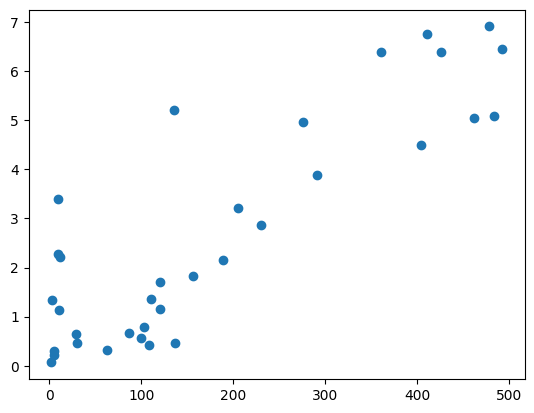

In [8]:
plt.scatter(x,y)

In [9]:
from sklearn.model_selection import train_test_split

df = df[df["smiles"].notnull()]
df[df["smiles"].notnull()]
df = df.sort_values(by="sum", ascending=False).reset_index(drop=True)
smiles_all = list(df["smiles"])
y_all = list(df["sum"])
dt = df[df["FragID"].notnull()]
smiles_exp = list(dt["smiles"])
y_exp = list(df["sum"])

df = df[df["FragID"].isnull()]
smiles_list = df["smiles"].tolist()
y_true = df["sum"].tolist()

smiles_train, smiles_test, y_true_train, y_true_test = train_test_split(smiles_list, y_true, random_state=42)

In [10]:
from mordred import Calculator, descriptors
from rdkit import Chem

file_name = "../data/mordred_enamine.tsv"
calc = Calculator(descriptors, ignore_3D=True)
if not os.path.exists(file_name):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_all]
    dm = calc.pandas(mols)
    dm.to_csv(file_name, index=False)
else:
    dm = pd.read_csv(file_name, low_memory=False)

In [11]:
desc2module = {}
done_descs = set(list(dm.columns))
for d in calc.descriptors:
    desc_name = str(d)
    if desc_name not in done_descs:
        continue
    desc_module = str(type(d)).split("'")[1].split(".")[1]
    desc2module[desc_name] = desc_module

module2desc = collections.defaultdict(list)
for k,v in desc2module.items():
    module2desc[v] += [k]

In [12]:
from sklearn.preprocessing import RobustScaler, PowerTransformer

def clean_descriptor_datatype(data):
    def Float(x):
        try:
            return float(x)
        except:
            return np.nan
    
    desc_columns = list(data.columns)
    dd = collections.defaultdict(list)
    for col in desc_columns:
        v = []
        for x in data[col].tolist():
            v += [Float(x)]
        dd[col] = v
    return pd.DataFrame(dd)

def remove_nan_columns(data, max_nan=0.1):
    desc_columns = list(data.columns)
    keep_columns = []
    for col in desc_columns:
        v = np.array(data[col])
        n_nans = np.sum(np.isnan(v))
        if n_nans/len(v) > max_nan:
            continue
        keep_columns += [col]
    return data[keep_columns]

def impute(data):
    medians = []
    dd = {}
    for col in list(data.columns):
        v = np.array(data[col])
        m = np.nanmedian(v)
        v[np.isnan(v)] = m
        medians += [m]
        dd[col] = v
    dd = pd.DataFrame(dd, columns=list(data.columns))
    return dd

def remove_almost_constant_columns(data, max_most_abundant=0.9):
    desc_columns = list(data.columns)
    keep_columns = []
    for col in desc_columns:
        v = np.array(data[col])
        N = len(v)
        d = collections.defaultdict(int)
        for x in v:
            d[x] += 1
        d = sorted(d.items(), key=lambda x: -x[1])
        n = d[0][1]
        if n/N >= max_most_abundant:
            continue
        keep_columns += [col]
    return data[keep_columns]

def scale(data):
    scaler = RobustScaler()
    ds = scaler.fit_transform(data)
    ds = pd.DataFrame(ds, columns=list(data.columns))
    to_power = []
    desc_columns = list(data.columns)
    for col in desc_columns:
        v = np.array(ds[col])
        neg = np.sum(v < 0)
        pos = np.sum(v > 0)
        if neg < len(v)*0.25:
            continue
        if pos < len(v)*0.25:
            continue
        to_power += [col]
    to_scale = [col for col in list(data.columns) if col not in to_power]
    transf = PowerTransformer()
    dt = transf.fit_transform(ds[to_power])
    dt = pd.DataFrame(dt, columns=to_power)
    ds = ds[to_scale]
    df = pd.concat([dt, ds], axis=1)
    df = df[list(data.columns)]
    df = np.array(df)
    df = np.clip(df, -3, 3)
    df = pd.DataFrame(df, columns=list(data.columns))
    return df
    
dm = clean_descriptor_datatype(dm)
dm = remove_nan_columns(dm)
dm = impute(dm)
dm = remove_almost_constant_columns(dm)
dm = scale(dm)

In [13]:
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from tqdm import tqdm

X = np.array(dm)
idxs = []
for i, smi in enumerate(smiles_all):
    if smi in smiles_train:
        idxs += [i]
X = X[idxs]
dtr = pd.DataFrame(X, columns=list(dm.columns))
ytr = [y_all[i] for i in idxs]

clusters = collections.defaultdict(list)
for k,v in tqdm(module2desc.items()):
    v = list(set(v).intersection(list(dtr.columns)))
    if len(v) == 0:
        continue
    X = np.array(dtr[v]).T
    n_clusters = min(5, len(v))
    clust = KMeans(n_clusters=n_clusters)
    clust.fit(X)
    labels = clust.labels_
    clusters_ = collections.defaultdict(list)
    for i, l in enumerate(labels):
        clusters_[l] += [v[i]]
    for u,w in clusters_.items():
        W = dtr[w]
        sel = SelectKBest(score_func=f_regression, k=1)
        sel.fit(W, ytr)
        best_feature = sel.get_feature_names_out()[0]
        clusters[(k, u, best_feature)] = w

dtr = dtr[[k[-1] for k, _ in clusters.items()]]
sel = SelectKBest(score_func=f_regression, k=100)
sel.fit(dtr, ytr)
dtr = dtr[list(sel.get_feature_names_out())]

  0%|                                                                                                                                                                                                                           | 0/45 [00:00<?, ?it/s]/Users/mduranfrigola/miniconda3/envs/topicmodel/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/topicmodel/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/topicmodel/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_i

In [14]:
from flaml import AutoML
import shap

mdl = AutoML(task="regression", estimator_list=['lgbm'])
mdl.fit(np.array(dtr), np.array(ytr), time_budget=60*30)

[flaml.automl.automl: 04-07 13:53:36] {2726} INFO - task = regression
[flaml.automl.automl: 04-07 13:53:36] {2728} INFO - Data split method: uniform
[flaml.automl.automl: 04-07 13:53:36] {2731} INFO - Evaluation method: cv
[flaml.automl.automl: 04-07 13:53:36] {2858} INFO - Minimizing error metric: 1-r2
[flaml.automl.automl: 04-07 13:53:36] {3004} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.automl: 04-07 13:53:36] {3334} INFO - iteration 0, current learner lgbm


/Users/mduranfrigola/miniconda3/envs/topicmodel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[flaml.automl.automl: 04-07 13:53:36] {3472} INFO - Estimated sufficient time budget=883s. Estimated necessary time budget=1s.
[flaml.automl.automl: 04-07 13:53:36] {3519} INFO -  at 0.1s,	estimator lgbm's best error=0.7045,	best estimator lgbm's best error=0.7045
[flaml.automl.automl: 04-07 13:53:36] {3334} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 04-07 13:53:36] {3519} INFO -  at 0.2s,	estimator lgbm's best error=0.7045,	best estimator lgbm's best error=0.7045
[flaml.automl.automl: 04-07 13:53:36] {3334} INFO - iteration 2, current learner lgbm
[flaml.automl.automl: 04-07 13:53:36] {3519} INFO -  at 0.3s,	estimator lgbm's best error=0.4495,	best estimator lgbm's best error=0.4495
[flaml.automl.automl: 04-07 13:53:36] {3334} INFO - iteration 3, current learner lgbm
[flaml.automl.automl: 04-07 13:53:36] {3519} INFO -  at 0.4s,	estimator lgbm's best error=0.2805,	best estimator lgbm's best error=0.2805
[flaml.automl.automl: 04-07 13:53:36] {3334} INFO - iteration 4

In [15]:
idxs = []
for i, smi in enumerate(smiles_all):
    if smi in smiles_test:
        idxs += [i]
X = np.array(dm)
X = X[idxs]
dte = pd.DataFrame(X, columns=list(dm.columns))
dte = dte[list(dtr.columns)]
yte = [y_all[i] for i in idxs]

idxs = []
smi_ex = []
for i, smi in enumerate(smiles_all):
    if smi in smiles_exp:
        idxs += [i]
        smi_ex += [smi]
X = np.array(dm)
X = X[idxs]
dex = pd.DataFrame(X, columns=list(dm.columns))
dex = dex[list(dtr.columns)]
yex = [y_all[i] for i in idxs]

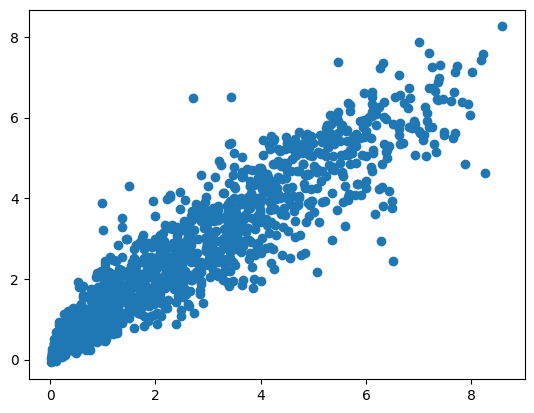

In [16]:
model_tr = mdl.model.estimator
model_tr.fit(np.array(dtr), ytr)

y_pred_te = model_tr.predict(np.array(dte))
plt.scatter(yte, y_pred_te)

In [17]:
explainer = shap.Explainer(model_tr)
shap_te = explainer(dte, check_additivity=False)

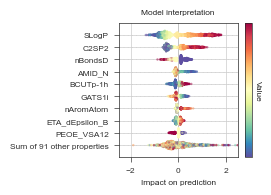

In [117]:
from __future__ import division

import warnings
import numpy as np
import scipy as sp
from scipy.stats import gaussian_kde
try:
    import matplotlib.pyplot as pl
except ImportError:
    warnings.warn("matplotlib could not be loaded!")
    pass
from shap.plots._labels import labels
from shap.plots import colors
from shap.utils import safe_isinstance, OpChain, format_value
from shap.plots._utils import convert_ordering, convert_color, merge_nodes, get_sort_order, sort_inds
from shap import Explanation
from stylia import TWO_COLUMNS_WIDTH
import stylia

def beeswarm(shap_values, max_display=10, order=Explanation.abs.mean(0),
             clustering=None, cluster_threshold=0.5, color=None,
             axis_color="#333333", alpha=1, show=True, log_scale=False,
             color_bar=True, plot_size="auto", color_bar_label=labels["FEATURE_VALUE"]):

    if not isinstance(shap_values, Explanation):
        raise ValueError("the beeswarm plot requires Explanation object as the `shap_values` argument")

    shap_exp = shap_values
    # we make a copy here, because later there are places that might modify this array
    values = np.copy(shap_exp.values)
    features = shap_exp.data
    if sp.sparse.issparse(features):
        features = features.toarray()
    feature_names = shap_exp.feature_names
    # if out_names is None: # TODO: waiting for slicer support
    #     out_names = shap_exp.output_names

    order = convert_ordering(order, values)

    # default color:
    if color is None:
        if features is not None:
            color = colors.red_blue
        else:
            color = colors.blue_rgb
    color = convert_color(color)

    idx2cat = None
    # convert from a DataFrame or other types
    if str(type(features)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = features.columns
        # feature index to category flag
        idx2cat = features.dtypes.astype(str).isin(["object", "category"]).tolist()
        features = features.values
    elif isinstance(features, list):
        if feature_names is None:
            feature_names = features
        features = None
    elif (features is not None) and len(features.shape) == 1 and feature_names is None:
        feature_names = features
        features = None

    num_features = values.shape[1]

    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(num_features)])

    if log_scale:
        pl.xscale('symlog')

    if clustering is None:
        partition_tree = getattr(shap_values, "clustering", None)
        if partition_tree is not None and partition_tree.var(0).sum() == 0:
            partition_tree = partition_tree[0]
        else:
            partition_tree = None
    elif clustering is False:
        partition_tree = None
    else:
        partition_tree = clustering
    
    if partition_tree is not None:
        assert partition_tree.shape[1] == 4, "The clustering provided by the Explanation object does not seem to be a partition tree (which is all shap.plots.bar supports)!"

    # determine how many top features we will plot
    if max_display is None:
        max_display = len(feature_names)
    num_features = min(max_display, len(feature_names))

    # iteratively merge nodes until we can cut off the smallest feature values to stay within
    # num_features without breaking a cluster tree
    orig_inds = [[i] for i in range(len(feature_names))]
    orig_values = values.copy()
    while True:
        feature_order = convert_ordering(order, Explanation(np.abs(values)))
        if partition_tree is not None:

            # compute the leaf order if we were to show (and so have the ordering respect) the whole partition tree
            clust_order = sort_inds(partition_tree, np.abs(values))

            # now relax the requirement to match the parition tree ordering for connections above cluster_threshold
            dist = scipy.spatial.distance.squareform(scipy.cluster.hierarchy.cophenet(partition_tree))
            feature_order = get_sort_order(dist, clust_order, cluster_threshold, feature_order)
        
            # if the last feature we can display is connected in a tree the next feature then we can't just cut
            # off the feature ordering, so we need to merge some tree nodes and then try again.
            if max_display < len(feature_order) and dist[feature_order[max_display-1],feature_order[max_display-2]] <= cluster_threshold:
                #values, partition_tree, orig_inds = merge_nodes(values, partition_tree, orig_inds)
                partition_tree, ind1, ind2 = merge_nodes(np.abs(values), partition_tree)
                for i in range(len(values)):
                    values[:,ind1] += values[:,ind2]
                    values = np.delete(values, ind2, 1)
                    orig_inds[ind1] += orig_inds[ind2]
                    del orig_inds[ind2]
            else:
                break
        else:
            break

    # here we build our feature names, accounting for the fact that some features might be merged together
    feature_inds = feature_order[:max_display]
    y_pos = np.arange(len(feature_inds), 0, -1)
    feature_names_new = []
    for pos,inds in enumerate(orig_inds):
        if len(inds) == 1:
            feature_names_new.append(feature_names[inds[0]])
        elif len(inds) <= 2:
            feature_names_new.append(" + ".join([feature_names[i] for i in inds]))
        else:
            max_ind = np.argmax(np.abs(orig_values).mean(0)[inds])
            feature_names_new.append(feature_names[inds[max_ind]] + " + %d other features" % (len(inds)-1))
    feature_names = feature_names_new

    # see how many individual (vs. grouped at the end) features we are plotting
    if num_features < len(values[0]):
        num_cut = np.sum([len(orig_inds[feature_order[i]]) for i in range(num_features-1, len(values[0]))])
        values[:,feature_order[num_features-1]] = np.sum([values[:,feature_order[i]] for i in range(num_features-1, len(values[0]))], 0)
    
    # build our y-tick labels
    yticklabels = [feature_names[i] for i in feature_inds]
    if num_features < len(values[0]):
        yticklabels[-1] = "Sum of %d other properties" % num_cut
    
    row_height = 0.4
    if plot_size == "auto":
        pl.gcf().set_size_inches(8, min(len(feature_order), max_display) * row_height + 1.5)
    elif type(plot_size) in (list, tuple):
        pl.gcf().set_size_inches(plot_size[0], plot_size[1])
    elif plot_size is not None:
        pl.gcf().set_size_inches(8, min(len(feature_order), max_display) * plot_size + 1.5)
    pl.axvline(x=0, color="#999999", zorder=-1)

    # make the beeswarm dots
    for pos, i in enumerate(reversed(feature_inds)):
        pl.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)
        shaps = values[:, i]
        fvalues = None if features is None else features[:, i]
        inds = np.arange(len(shaps))
        np.random.shuffle(inds)
        if fvalues is not None:
            fvalues = fvalues[inds]
        shaps = shaps[inds]
        colored_feature = True
        try:
            if idx2cat is not None and idx2cat[i]: # check categorical feature
                colored_feature = False
            else:
                fvalues = np.array(fvalues, dtype=np.float64)  # make sure this can be numeric
        except:
            colored_feature = False
        N = len(shaps)
        # hspacing = (np.max(shaps) - np.min(shaps)) / 200
        # curr_bin = []
        nbins = 100
        quant = np.round(nbins * (shaps - np.min(shaps)) / (np.max(shaps) - np.min(shaps) + 1e-8))
        inds = np.argsort(quant + np.random.randn(N) * 1e-6)
        layer = 0
        last_bin = -1
        ys = np.zeros(N)
        for ind in inds:
            if quant[ind] != last_bin:
                layer = 0
            ys[ind] = np.ceil(layer / 2) * ((layer % 2) * 2 - 1)
            layer += 1
            last_bin = quant[ind]
        ys *= 0.9 * (row_height / np.max(ys + 1))

        if safe_isinstance(color, "matplotlib.colors.Colormap") and features is not None and colored_feature:
            # trim the color range, but prevent the color range from collapsing
            vmin = np.nanpercentile(fvalues, 5)
            vmax = np.nanpercentile(fvalues, 95)
            if vmin == vmax:
                vmin = np.nanpercentile(fvalues, 1)
                vmax = np.nanpercentile(fvalues, 99)
                if vmin == vmax:
                    vmin = np.min(fvalues)
                    vmax = np.max(fvalues)
            if vmin > vmax: # fixes rare numerical precision issues
                vmin = vmax

            assert features.shape[0] == len(shaps), "Feature and SHAP matrices must have the same number of rows!"

            # plot the nan fvalues in the interaction feature as grey
            nan_mask = np.isnan(fvalues)
            pl.scatter(shaps[nan_mask], pos + ys[nan_mask], color="#777777", vmin=vmin,
                        vmax=vmax, s=3, alpha=alpha, linewidth=0,
                        zorder=3, rasterized=len(shaps) > 500)

            # plot the non-nan fvalues colored by the trimmed feature value
            cvals = fvalues[np.invert(nan_mask)].astype(np.float64)
            cvals_imp = cvals.copy()
            cvals_imp[np.isnan(cvals)] = (vmin + vmax) / 2.0
            cvals[cvals_imp > vmax] = vmax
            cvals[cvals_imp < vmin] = vmin
            pl.scatter(shaps[np.invert(nan_mask)], pos + ys[np.invert(nan_mask)],
                        cmap=color, vmin=vmin, vmax=vmax, s=3,
                        c=cvals, alpha=alpha, linewidth=0,
                        zorder=3, rasterized=len(shaps) > 500)
        else:

            pl.scatter(shaps, pos + ys, s=3, alpha=alpha, linewidth=0, zorder=3,
                        color=color if colored_feature else "#777777", rasterized=len(shaps) > 500)


    # draw the color bar
    if safe_isinstance(color, "matplotlib.colors.Colormap") and color_bar and features is not None:
        import matplotlib.cm as cm
        m = cm.ScalarMappable(cmap=color)
        m.set_array([0, 1])
        cb = pl.colorbar(m, ticks=[0, 1], aspect=20)
        cb.set_ticklabels([labels['FEATURE_VALUE_LOW'], labels['FEATURE_VALUE_HIGH']])
        cb.set_ticklabels("")
        cb.set_label(color_bar_label, size=6, labelpad=1, rotation=270, va="center", ha="center")
        cb.ax.tick_params(labelsize=6, length=0)
        cb.set_alpha(1)

    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('left')
    pl.gca().tick_params(color=axis_color, labelcolor=axis_color)
    pl.yticks(range(len(feature_inds)), reversed(yticklabels), fontsize=6)
    pl.gca().tick_params('y', width=0.5, which='major')
    pl.gca().tick_params('x', width=0.5, labelsize=6)
    pl.ylim(-1, len(feature_inds))
    pl.xlabel("Impact on prediction", fontsize=6)
    pl.grid()
    pl.tight_layout()
    ax = pl.gca()
    return ax
    
ax = beeswarm(shap_te, color=plt.get_cmap("Spectral_r"), plot_size=(TWO_COLUMNS_WIDTH/2.6,TWO_COLUMNS_WIDTH/4), alpha=0.5, color_bar_label="Value")
ax = stylia.figure.figure.stylize(ax)
ax.grid(lw=0.5)
ax.set_xlim(-2.5, 2.5)

ax.set_title("Model interpretation", fontsize=6)
stylia.label(ax, ylabel="", xlabel="Impact on prediction")
#stylia.save_figure("../assets/beeswarm.png")

In [19]:
idxs = []
for i, smi in enumerate(smiles_all):
    if smi in smiles_list:
        idxs += [i]
X = np.array(dm)
X = X[idxs]
dfu = pd.DataFrame(X, columns=list(dm.columns))
dfu = dfu[list(dtr.columns)]
yfu = [y_all[i] for i in idxs]

mdl = AutoML(task="regression", estimator_list=['lgbm'])
mdl.fit(np.array(dfu), np.array(yfu), time_budget=60*30)
model_fu = mdl.model.estimator
model_fu.fit(np.array(dfu), yfu)

[flaml.automl.automl: 04-07 14:23:21] {2726} INFO - task = regression
[flaml.automl.automl: 04-07 14:23:21] {2728} INFO - Data split method: uniform
[flaml.automl.automl: 04-07 14:23:21] {2731} INFO - Evaluation method: cv
[flaml.automl.automl: 04-07 14:23:21] {2858} INFO - Minimizing error metric: 1-r2
[flaml.automl.automl: 04-07 14:23:21] {3004} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.automl: 04-07 14:23:21] {3334} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 04-07 14:23:21] {3472} INFO - Estimated sufficient time budget=1044s. Estimated necessary time budget=1s.
[flaml.automl.automl: 04-07 14:23:21] {3519} INFO -  at 0.1s,	estimator lgbm's best error=0.6958,	best estimator lgbm's best error=0.6958
[flaml.automl.automl: 04-07 14:23:21] {3334} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 04-07 14:23:21] {3519} INFO -  at 0.2s,	estimator lgbm's best error=0.6958,	best estimator lgbm's best error=0.6958
[flaml.automl.automl: 0

LGBMRegressor(colsample_bytree=0.6049832890774616,
              learning_rate=0.029340053408865467, max_bin=1023,
              min_child_samples=6, n_estimators=5598, num_leaves=17,
              reg_alpha=0.000996743598444551, reg_lambda=0.0949484770672903,
              verbose=-1)

In [20]:
import joblib
joblib.dump(model_fu, "../results/model_fu.joblib")
joblib.dump(model_tr, "../results/model_tr.joblib")

['../results/model_tr.joblib']

In [21]:
y_pred_ex = model_fu.predict(dex)

In [116]:
joblib.dump((smi_ex, yex, y_pred_ex), "../results/ex_data.joblib")

['../results/ex_data.joblib']

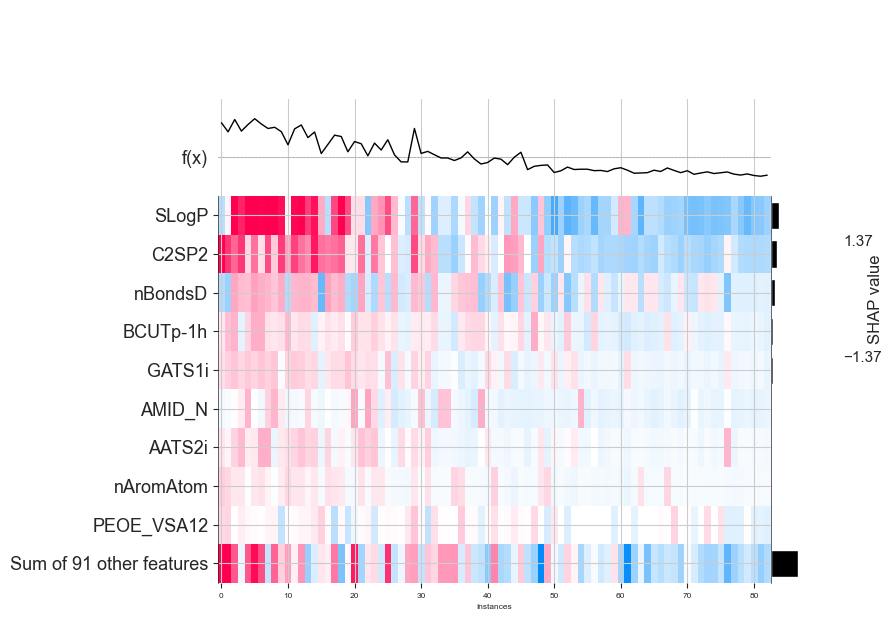

In [22]:
explainer = shap.Explainer(model_fu)
shap_ex = explainer(dex)
shap.plots.heatmap(shap_ex, max_display=10, instance_order=np.array([i for i in range(dex.shape[0])]))

In [23]:
from griddify import Griddify

gf = Griddify(preprocess=False)
gf.fit(dm[list(dtr.columns)])
grid_names = {}
for i,v in enumerate(gf.mappings):
    grid_names[tuple(v)] = list(dex.columns)[i]

name_grid = dict((v,k) for k,v in grid_names.items())

1it [00:00, 18.12it/s]


In [114]:
joblib.dump(grid_names, "../results/grid_names.joblib")
joblib.dump(name_grid, "../results/name_grid.joblib")
joblib.dump(dex, "../results/dex.joblib")
joblib.dump(shap_te, "../results/shap_te.joblib")

['../results/shap_te.joblib']

In [25]:
rename_columns = {
    "C2SP2": "SP2 Carbons",
    "VSA_EState6": "Carbon VdW surface area",
    "SLogP": "Wildman-Crippen LogP",
    "SdO": "SP2 Oxygens",
    "BCUTp-1h": "Burden mat. by polarizability",
    "ETA_dEpsilon_B": "Extended topochemical atom",
    "GATS1i": "Geary coefficient",
    "nAromAtom": "Aromatic atoms count",
    "nBondsD": "Bonds in non-kekulized struct."
}

In [26]:
from stylia import ContinuousColorMap, NamedColorMaps
from matplotlib.patches import Rectangle

cmap_data = ContinuousColorMap(NamedColorMaps(scientific=False).spectral)
cmap_data.fit(np.linspace(-3, 3, 1000))

cmap_shap = ContinuousColorMap(NamedColorMaps(scientific=False).coolwarm)
cmap_shap.fit(np.linspace(-0.1, 0.1, 1000))

In [27]:
X = gf.transform(dex)
S = gf.transform(shap_ex.values)

In [115]:
joblib.dump((X, S), "../results/ex_matrices.joblib")

['../results/ex_matrices.joblib']

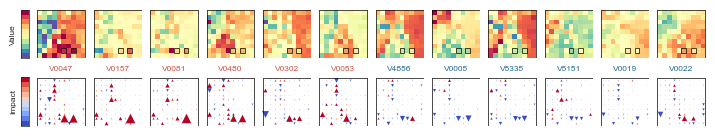

In [110]:
import stylia
from stylia import TWO_COLUMNS_WIDTH
from stylia import NamedColors

def grid_values_plot(ax, x, label=False):
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x_ = x[i,j]
            c_ = cmap_data.transform([-x_])[0]
            r = Rectangle((i,j), 1, 1, color=c_, edgecolor="none", lw=0)
            ax.add_patch(r)
    ax.set_xlim(-0.1, x.shape[0]+0.1)
    ax.set_ylim(-0.1, x.shape[1]+0.1)
    ax.axes.set_axis_off()
    n = x.shape[0]
    ax.plot([0, n], [0,0], lw = 0.5, color="black")
    ax.plot([0, n], [n,n], lw = 0.5, color="black")
    ax.plot([0, 0], [0,n], lw = 0.5, color="black")
    ax.plot([n, n], [0,n], lw = 0.5, color="black")
    for l in ["SLogP", "C2SP2"]:
        i,j = name_grid[l]
        r = Rectangle((i,j), 1,1, facecolor="none", edgecolor="black", lw=0.5)
        ax.add_patch(r)
    

def grid_shap_plot(ax, x):
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x_ = x[i,j]
            c_ = cmap_shap.transform([x_])[0]
            if x_ >= 0:
                m = "^"
            else:
                m = "v"
            ax.scatter([i+0.5], [j+0.5], marker=m, color=c_, s=np.abs(x_)*30, zorder=2, lw=0)
    ax.set_xlim(-0.1, x.shape[0]+0.1)
    ax.set_ylim(-0.1, x.shape[1]+0.1)
    ax.axes.set_axis_off()
    n = x.shape[0]
    ax.plot([0, n], [0,0], lw = 0.5, color="black")
    ax.plot([0, n], [n,n], lw = 0.5, color="black")
    ax.plot([0, 0], [0,n], lw = 0.5, color="black")
    ax.plot([n, n], [0,n], lw = 0.5, color="black")

fig, axs = stylia.create_figure(nrows=2, ncols=13, width_ratios=[0.5] + [3]*12, width=TWO_COLUMNS_WIDTH, height=TWO_COLUMNS_WIDTH/5.4)
c = 0
ax = axs[c]
v = np.linspace(-3, 3, 10)
colors = cmap_data.transform(v)[::-1]
for i, c_ in enumerate(colors):
    r = Rectangle((0,i), 1, 1, edgecolor="none", facecolor=c_)
    ax.add_patch(r)
ax.set_xlim(0,1)
ax.set_ylim(0,len(colors))
ax.set_xticks([])
ax.set_yticks([])
stylia.label(ax, title="", ylabel="", xlabel="")
ax.text(-1, 5, "Value", rotation=90, va="center", ha="center", fontsize=6)
X_ = X[sel_idxs]
c += 1
for i in range(X_.shape[0]):
    if i == 0:
        label = True
    else:
        label = False
    ax = axs[c]
    grid_values_plot(ax, X_[i], label=label)
    stylia.label(ax, title="")
    c += 1
ax = axs[c]
v = np.linspace(-0.1, 0.1, 10)
colors = cmap_shap.transform(v)
for i, c_ in enumerate(colors):
    r = Rectangle((0,i), 1, 1, edgecolor="none", facecolor=c_)
    ax.add_patch(r)
ax.set_xlim(0,1)
ax.set_ylim(0,len(colors))
ax.set_xticks([])
ax.set_yticks([])
stylia.label(ax, title="", ylabel="", xlabel="")
ax.text(-1, 5, "Impact", rotation=90, va="center", ha="center", fontsize=6)
c += 1
S_ = S[sel_idxs]
for i in range(S_.shape[0]):
    ax = axs[c]
    grid_shap_plot(ax, S_[i])
    if i < 6:
        color = NamedColors().red
    else:
        color = NamedColors().blue
    ax.text(5, 12, sel_fids[i], va="center", ha="center", fontsize=6, color=color)
    c += 1
    stylia.label(ax, title="")

stylia.save_figure("../interpretability_plot_proposal.png")

In [44]:
df = pd.read_csv("../data/enamine_stock_miniautoml_predictions.tsv", sep="\t")
cols = ["catalog_id", "fid", "original_validation", "smiles"] + [x for x in list(df.columns) if x.startswith("promiscuity")]
df = df[cols]

frag_ids = []
for fid in df["fid"].tolist():
    if str(fid) == "nan":
        frag_ids += [np.nan]
    else:
        frag_id = fid.split("-")[1]
        if len(frag_id) == 5:
            frag_ids += [frag_id]
        else:
            if frag_id == "V059":
                frag_id = "V0081"
            elif frag_id == "V060":
                frag_id = "V0157"
            elif frag_id == "V062":
                frag_id = "V0302"
            elif frag_id == "V065":
                frag_id = "V0480"
            else:
                frag_id = frag_id.replace("V", "V0")
            frag_ids += [frag_id]
df["FragID"] = frag_ids

smi2fid = {}
for r in df[["FragID", "smiles"]].values:
    if str(r[1]) == "nan":
        continue
    smi2fid[r[1]] = r[0]
fid_ex = [smi2fid[r] for r in smi_ex]

In [99]:
truth = sorted(fragment_counts.items(), key=lambda x: -x[1])
prediction_score = [pred[k[0]] for k in truth]
surrogate_score = dict((x, y) for x,y in zip(fid_ex, y_pred_ex))
slogps = dict((x,y) for x,y in zip(fid_ex, dex["SLogP"].tolist()))

In [101]:
R = []
for t, u in zip(truth, prediction_score):
    R += [[t[0], t[1], u, surrogate_score[t[0]], slogps[t[0]]]]
dr = pd.DataFrame(R, columns=["fid", "counts", "score", "surrogate", "slogp"])

In [65]:
sel_idxs = [fid_ex.index(r) for r in list(dr["fid"])]

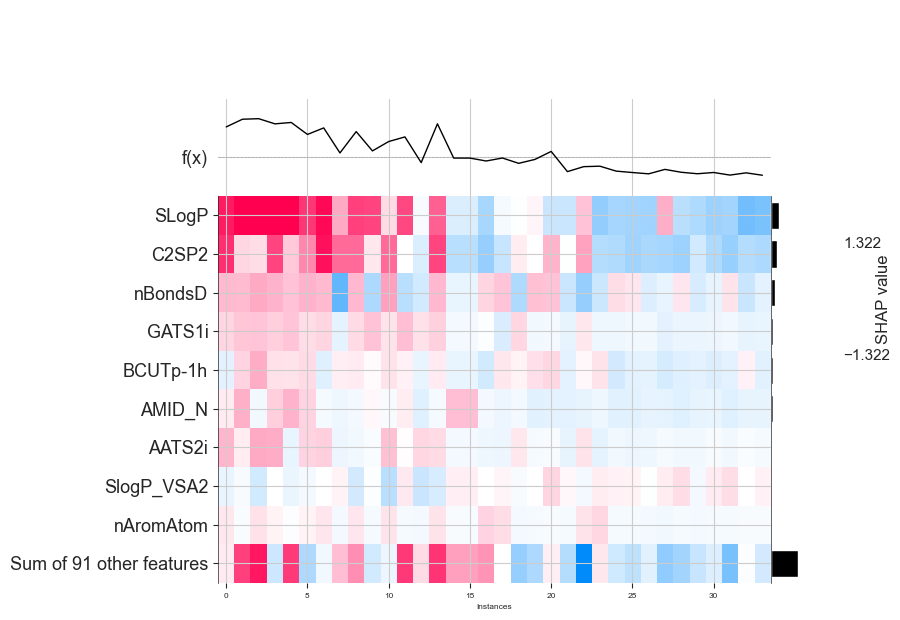

In [73]:
explainer = shap.Explainer(model_fu)
dex_sel = dex.copy()
dex_sel["fid"] = fid_ex
dex_sel = dex_sel[dex_sel["fid"].isin(dr["fid"].tolist())]
dex_sel = dex_sel.drop(columns=["fid"], inplace=False)
shap_ex = explainer(dex_sel)
shap.plots.heatmap(shap_ex, max_display=10, instance_order=np.array([i for i in range(dex_ary.shape[0])]))

         ABC     ABCGG    SpAD_A   SpMAD_A  nAromAtom  nAromBond   nHetero  \
0   1.555772  1.383091  1.729914  1.558205   3.000000   2.840249 -0.704843   
1   0.084168  0.629935  0.051882 -0.165156  -0.033571  -0.052428 -0.704843   
2  -0.608018 -0.790297 -0.465625  1.065591   1.370418   1.279977 -0.704843   
3   0.700595  0.084927  0.968536  1.167022   1.651143   1.542352 -1.566277   
4   0.084168 -0.014955  0.034520 -0.254403  -0.033571  -0.052428  0.079434   
5  -0.337470 -0.407905 -0.111558  1.041317   1.089673   1.279977 -1.566277   
6   1.491489  1.398625  1.796658  2.035951   3.000000   2.840249  0.079434   
7   1.789054  2.066913  1.461980 -1.309540  -0.033571  -0.052428  0.775137   
8   1.009812  0.653524  0.907645  0.758963   2.212541   2.323589  0.775137   
9   1.189983  0.996054  0.560131 -2.018338  -0.033571  -0.052428  1.408201   
10 -0.268711 -0.654270 -0.118712  0.987469   1.089673   1.279977 -1.566277   
11  1.460053  1.385356  1.315308 -0.656228  -0.033571  -0.052428

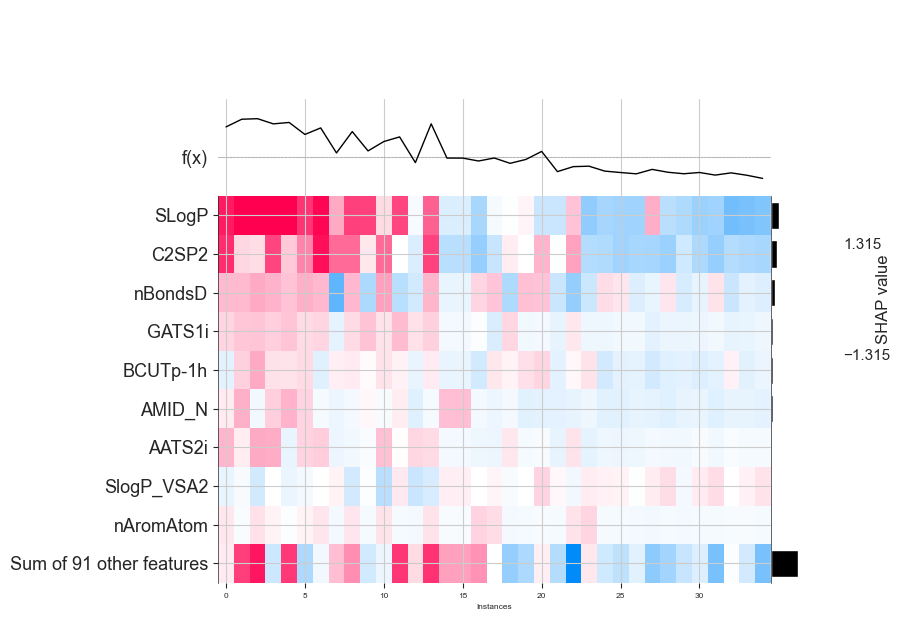

In [94]:
explainer = shap.Explainer(model_fu)
dex_sel = dex.copy()
dex_sel["fid"] = fid_ex
dex_sel = dex_sel[dex_sel["fid"].isin(dr["fid"].tolist())]
dex_sel = dex_sel.merge(dr, on="fid", how="left")
print(dex_sel)
dex_sel = dex_sel.sort_values(by="score", ascending=False)
my_fids = dex_sel["fid"].tolist()
dex_sel = dex_sel.drop(columns=list(dr.columns), inplace=False)
shap_ex = explainer(dex_sel)
shap.plots.heatmap(shap_ex, max_display=10, instance_order=np.array([i for i in range(dex_sel.shape[0])]))

In [104]:
sel_fids = ["V0047", "V0157", "V0081", "V0480", "V0302", "V0053", "V4856", "V0005", "V5335", "V5151", "V0019", "V0022"]
sel_idxs = [fid_ex.index(x) for x in sel_fids]